In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils import data
import matplotlib.pyplot as plt
from torch import nn

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(
    root='../data', train=True, transform=transforms.ToTensor(), download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root='../data', train=False, transform=transforms.ToTensor(), download=True
)

In [3]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols*scale, num_rows*scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax,img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.set_title(titles[i])
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    return axes

array([<AxesSubplot:title={'center':'tensor(9)'}>,
       <AxesSubplot:title={'center':'tensor(0)'}>,
       <AxesSubplot:title={'center':'tensor(0)'}>,
       <AxesSubplot:title={'center':'tensor(3)'}>,
       <AxesSubplot:title={'center':'tensor(0)'}>,
       <AxesSubplot:title={'center':'tensor(2)'}>,
       <AxesSubplot:title={'center':'tensor(7)'}>,
       <AxesSubplot:title={'center':'tensor(2)'}>,
       <AxesSubplot:title={'center':'tensor(5)'}>,
       <AxesSubplot:title={'center':'tensor(5)'}>,
       <AxesSubplot:title={'center':'tensor(0)'}>,
       <AxesSubplot:title={'center':'tensor(9)'}>,
       <AxesSubplot:title={'center':'tensor(5)'}>,
       <AxesSubplot:title={'center':'tensor(5)'}>,
       <AxesSubplot:title={'center':'tensor(7)'}>,
       <AxesSubplot:title={'center':'tensor(9)'}>,
       <AxesSubplot:title={'center':'tensor(1)'}>,
       <AxesSubplot:title={'center':'tensor(0)'}>], dtype=object)

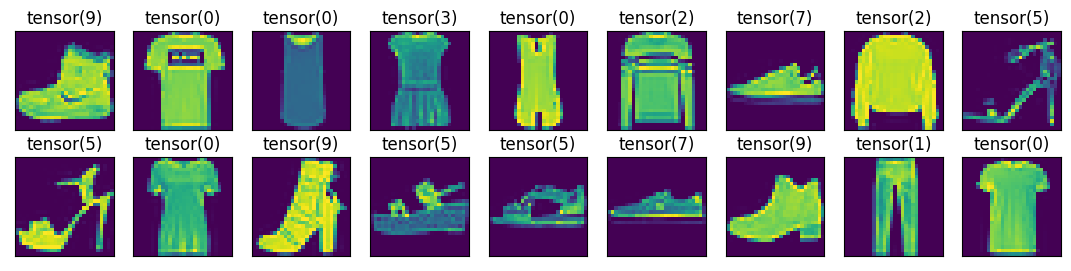

In [4]:
batch_size = 18
x,y = next(iter(data.DataLoader(mnist_train, batch_size=batch_size)))
show_images(x.reshape(batch_size, 28, 28), 2, 9, titles=y)

In [5]:
# 准备数据
batch_size = 256
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4)
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=4)

In [6]:
num_out = 10
num_input = 28*28
w = torch.normal(0, 0.01, (28*28, 10), requires_grad=True)
b = torch.zeros(num_out, requires_grad=True)

In [7]:
# 前向传播
def softmax(x):
    x_exp = torch.exp(x)
    return x_exp/x_exp.sum(1, keepdim=True)

def net(x, w, b):
    # x shape (batch_size, 28*28)
    # w (28*28, 10)
    y = torch.matmul(x.reshape((-1, w.shape[0])),w)+b
    return softmax(y)

# 代价函数
def cross_entropy(y, y_hat):
    return  - torch.log(y_hat[range(len(y_hat)), y])

# sgd
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad/batch_size
            param.grad.zero_()

y = torch.tensor([0])
y_hat = torch.tensor([[0.6, 0.3, 0.1]])
cross_entropy(y, y_hat)

# 准确率
def ac(w, b, data_iter, net):
    for x,y in data_iter:
        y_hat = net(x,w,b)
        maxs, indexs = torch.max(y_hat, dim=1)
        num_ac = y.eq(indexs).sum()/indexs.shape[0]
        return num_ac

In [8]:
lr = 0.1
num_epochs = 10
net = net
loss = cross_entropy

In [9]:
# for i in range(num_epochs):
#     for x,y in train_iter:
#         y_hat = net(x, w, b)
#         l = loss(y, y_hat)
#         l.sum().backward()
#         sgd([w,b], lr, batch_size)
#     print('epoch:{}, ac:{}'.format(i, ac(w, b, train_iter, net)))

In [10]:
# for x,y in test_iter:
#     data = net(x,w,b)
#     print(data.shape)
#     maxs, indexs = torch.max(data, dim=1)
#     num_ac = y.eq(indexs).sum()/batch_size
#     print(indexs.shape)
#     print(num_ac)
#     break

In [11]:
# torch.save(w, 'w.pt')
# torch.save(b, 'b.pt')

In [12]:
# torch.load('w.pt').shape

# 简洁实现

In [13]:
a = torch.arange(24).reshape((2,3,4))
f = nn.Flatten()
# nn.Flatten()的第一个维度一般是batch
f(a).shape, torch.flatten(a).shape

(torch.Size([2, 12]), torch.Size([24]))

In [14]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 10))
net.apply(init_weights)
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [15]:
def ac(data_iter, net):
    for x,y in data_iter:
        y_hat = net(x)
        maxs, indexs = torch.max(y_hat, dim=1)
        num_ac = y.eq(indexs).sum()/indexs.shape[0]
        return num_ac


for i in range(num_epochs):
    for x,y in train_iter:
        y_hat = net(x)
        l = loss(y_hat, y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
    print('epoch:{}, ac:{}'.format(i, ac(train_iter, net)))

epoch:0, ac:0.7421875
epoch:1, ac:0.78515625
epoch:2, ac:0.7890625
epoch:3, ac:0.82421875
epoch:4, ac:0.81640625
epoch:5, ac:0.8125
epoch:6, ac:0.84375
epoch:7, ac:0.8515625
epoch:8, ac:0.82421875
epoch:9, ac:0.8125


In [30]:
loss_func = nn.CrossEntropyLoss()
pre = torch.tensor([[0.8, 0.5, 0.2, 0.5]], dtype=torch.float)
tgt = torch.tensor([[1, 0, 0, 0]], dtype=torch.float)

cross_entropy(0, torch.softmax(pre, dim=1)), loss_func(pre, tgt)

(tensor([1.1087]), tensor(1.1087))